In [ ]:

!pip install scikit-optimize

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, make_scorer, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from numpy.lib.stride_tricks import sliding_window_view


from skopt import BayesSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

---
## Preprocesado
---
Identico al de Treball Previ

In [ ]:
time_for_pred = 24

In [ ]:
# Cargar el conjunto de datos
data = pd.read_csv('dataset.csv')

# Crear características 'lagged'
for i in range(1, 2):
    data[f'lag_{i}'] = data['exits'].shift(i)

data['demand_satisfied_lag'] = data['demand_satisfied'].shift(1)
data = data.drop('demand_satisfied', axis=1)

# Crear una columna de fecha a partir de las columnas de año, mes y día
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

# Filtrar datos entre las fechas especificadas
start_date = pd.Timestamp('2022-01-01')
end_date = pd.Timestamp('2023-11-30')
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

data = data.drop('date', axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

split_index = int(len(data) - time_for_pred)

# Divide los datos en conjuntos de entrenamiento y prueba según el índice calculado
data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

# data_train, data_test = train_test_split(data, test_size=0.1, shuffle=False)

data_train.shape, data_test.shape

((16608, 17), (168, 17))

In [ ]:
from sklearn.impute import KNNImputer
data_imputer = data_train.drop('exits', axis=1)

knni_demand_satisfied_lag = KNNImputer(n_neighbors=10)
knni_initial_bikes = KNNImputer(n_neighbors=10)

i_demand_satisfied_lag = knni_demand_satisfied_lag.fit_transform(data_imputer)[:,-1]
i_initial_bikes = knni_initial_bikes.fit_transform(data_imputer)[:, 13]

# Redondear y convertir a enteros las columnas
i_demand_satisfied_lag = i_demand_satisfied_lag.round().astype(int)
i_initial_bikes = i_initial_bikes.round().astype(int)

data_train['demand_satisfied_lag'] = i_demand_satisfied_lag
data_train['initial_bikes'] = i_initial_bikes

<ipython-input-73-dab25ab3a451>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['demand_satisfied_lag'] = i_demand_satisfied_lag
<ipython-input-73-dab25ab3a451>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['initial_bikes'] = i_initial_bikes


In [ ]:
data_imputer = data_test.drop('exits', axis=1)

i_demand_satisfied_lag = knni_demand_satisfied_lag.transform(data_imputer)[:,-1]
i_initial_bikes = knni_initial_bikes.transform(data_imputer)[:, 13]

# Redondear y convertir a enteros las columnas
i_demand_satisfied_lag = i_demand_satisfied_lag.round().astype(int)
i_initial_bikes = i_initial_bikes.round().astype(int)

data_test['demand_satisfied_lag'] = i_demand_satisfied_lag
data_test['initial_bikes'] = i_initial_bikes

<ipython-input-74-39500e2f055e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['demand_satisfied_lag'] = i_demand_satisfied_lag
<ipython-input-74-39500e2f055e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['initial_bikes'] = i_initial_bikes


---
# **Gradient Boosting**
---



In [ ]:
results_df = pd.DataFrame(columns=['Model', 'R2 Score', 'MSE', 'RMSE', 'MAE'])

In [ ]:
X_train = data_train.drop('exits', axis=1)
y_train = data_train['exits']

X_test = data_test.drop('exits', axis=1)
y_test = data_test['exits']

In [ ]:
from cmath import sqrt
# Define the parameter search space for Gradient Boosting
param_space_gb = {
    'n_estimators': [50,100,150],
    'max_depth': [5,10,15],#(5, 15)
    'min_samples_split': [2,6,10], #(2, 10)
    'min_samples_leaf': [10,20,30], #[1,10,20,30],
    'learning_rate': [0.05,0.1,0.2]
}



# Create the Gradient Boosting model
gb = GradientBoostingRegressor()

# Configure TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3, gap=25)

# Configure BayesSearchCV for Gradient Boosting
gb_bs = BayesSearchCV(
    gb,
    param_space_gb,
    n_iter=30,
    cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),  # Note: BayesSearchCV uses neg_mean_squared_error for optimization
    n_jobs=-1,
    refit=True,
    random_state=0
)

# Fit the Gradient Boosting model with BayesSearchCV
gb_bs.fit(X_train, y_train)

# Best model and parameters found
best_gb = gb_bs.best_estimator_
best_params_gb = gb_bs.best_params_

# Evaluate the model on the test set
y_pred_gb = best_gb.predict(X_test)
r2_score_gb = r2_score(y_test, y_pred_gb)

# Print the best parameters and R2 score for Gradient Boosting with BayesSearchCV
print("Best parameters for Gradient Boosting (BayesSearchCV):", best_params_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)

# Assuming you have a DataFrame named results_df
results_df.loc[len(results_df)] = ["Gradient Boosting", r2_score_gb, mse_gb, sqrt(mse_gb), mae_gb]

# Print or use results_df as needed
print(results_df)


Best parameters for Gradient Boosting (BayesSearchCV): OrderedDict([('learning_rate', 0.1), ('max_depth', 5), ('min_samples_leaf', 20), ('min_samples_split', 2), ('n_estimators', 50)])
               Model  R2 Score      MSE                RMSE       MAE
0  Gradient Boosting   0.78567  4.78642  2.187789+0.000000j  1.368093


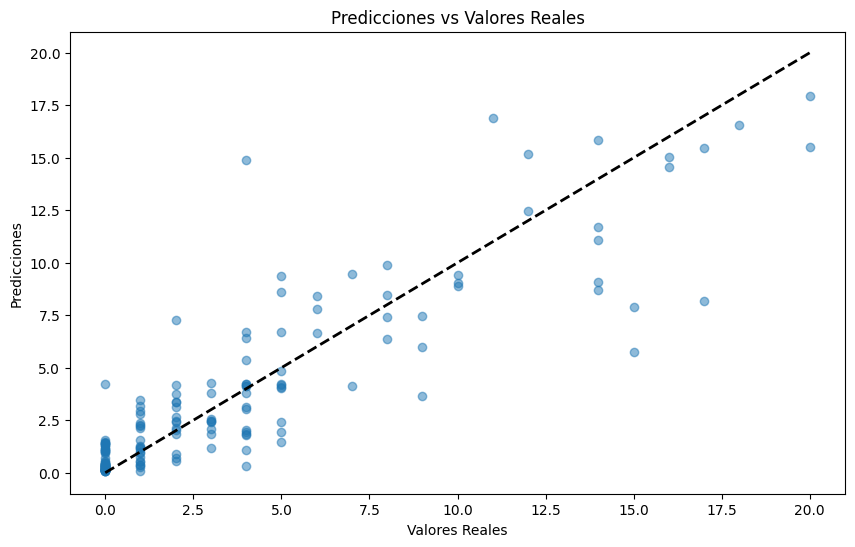

In [ ]:
# Realizar el gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea de perfecta predicción
plt.show();

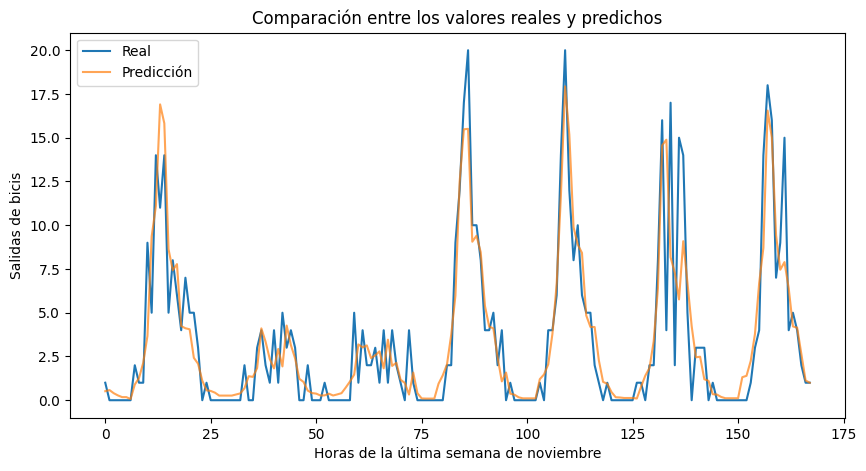

In [ ]:
# Graficar los valores reales vs. los predichos
plt.figure(figsize=(10, 5))
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.plot(y_pred_gb, label='Predicción', alpha=0.7)
plt.title('Comparación entre los valores reales y predichos')
plt.xlabel('Horas de la última semana de noviembre')
plt.ylabel('Salidas de bicis')
plt.legend()
plt.show();